OpenAI token:  ········


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the force as a function of time, t
def force(t):
    # Example: Constant force
    F = 10  # Newtons
    return F

# Define mass
m = 2  # kg

# Function to be used in solve_ivp, which computes the derivatives
def motion_equations(t, y):
    x, v = y  # y contains position and velocity
    dxdt = v
    dvdt = force(t) / m  # a = F/m
    return [dxdt, dvdt]

# Initial conditions: x(0) and v(0)
initial_conditions = [0, 0]  # Starting at x=0 with v=0

# Time span for the simulation: from t=0 to t=10 seconds
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 300)

# Solve the ODE
result = solve_ivp(motion_equations, t_span, initial_conditions, t_eval=t_eval)

# Extract results
time = result.t
position = result.y[0]
velocity = result.y[1]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, position, label='Position (m)')
plt.title('Position vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, velocity, label='Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

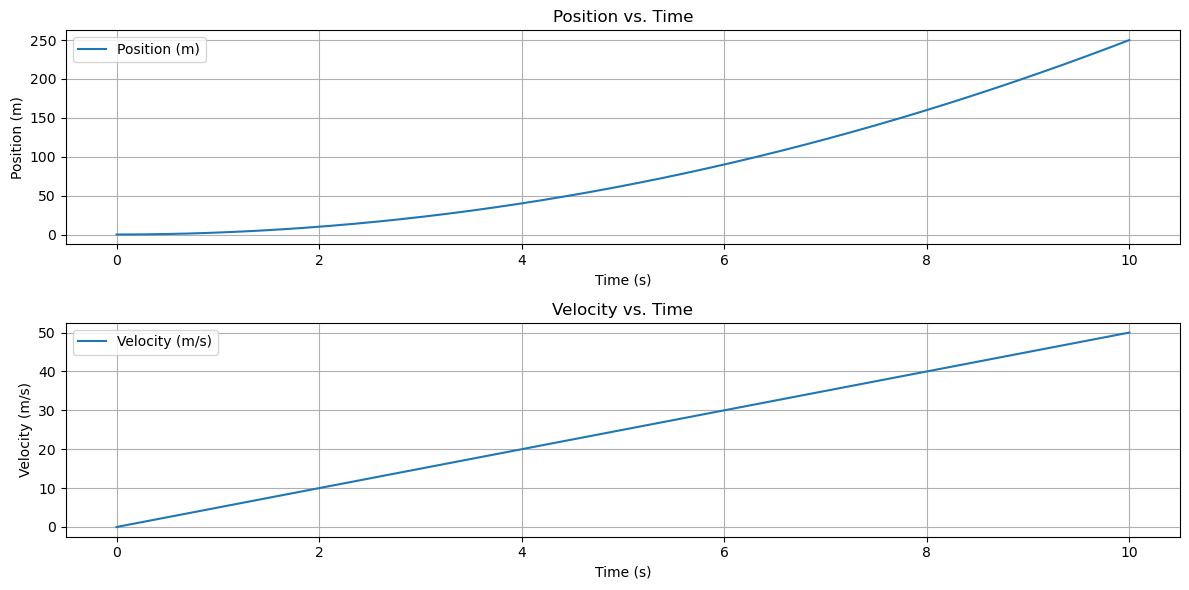

<IPython.core.display.Latex object>

In [ ]:
import openai
import getpass
import os
import sys
import re
from IPython.display import display, Math, Markdown, Latex, Code
from openai import OpenAI

ode = {
        "name": "Newton's Second Law of Motion",
        "equation": "d2x/dt2 = F/m",
        "description": "Describes the motion of a body under the influence of external forces."
}

#model = "gpt-3.5-turbo"
model = "gpt-4-turbo"

token = getpass.getpass(prompt='OpenAI token: ')
os.environ['OPENAI_API_KEY'] = token

prompts_start=[
    {"role": "system", "content": "You are a numerical algorithms assistant, skilled in explaining complex programming concepts in python. Please use latex formatting for all responses."},
    {"role": "user", "content": "What is an ordinary differential equation."}
  ]

user_prompts = [
        {"role": "user", "content": "Can you solve this ordinary differential equation: dxdt=0"},
        {"role": "user", "content": "Can you solve this ODE: dxdt=msint+nt3"},
        {"role": "user", "content": f"Can you solve this ODE: {ode}"},
        {"role": "user", "content": f"Can you generate the python code to solve this ODE: {ode}?"},
        {"role": "user", "content": "In the context of the current discussion, what is a discretization?"},
        {"role": "user", "content": "Where does the discretization occur in the python code that you generated?"},
        {"role": "user", "content": "In the context of the current discussion what is a solver?"},
        {"role": "user", "content": "In the example above, could you provide the equations of the edge cases?"},
        {"role": "user", "content": "Generate the code for these edge cases."},
        {"role": "user", "content": "Generate the code for a python module that contains the code that you generated that solves the ODE and the code that solves the edge cases. Please document the python module and provide installation instructions for the module and a couple of simple example scripts that use the module."}
]

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Extract Python code from response
def extract_python_code(response):
    if response.find('```python') == -1:
        python_code = None
    else:
        start_index = response.find('```python') + len('python```')
        end_index = response.find('```', start_index)
        python_code = response[start_index:end_index]
        
    return python_code

def remove_python_code(text):
    start_token = "```python"
    end_token = "```"
    
    # Find the start index of the substring
    start_index = text.find(start_token)
    
    # If start_token is found, find the end index of the substring
    if start_index != -1:
        # Adjust start_index to include the length of start_token to find the end correctly
        end_index = text.find(end_token, start_index + len(start_token))
        
        # If end_token is found, calculate the actual end index to include the end_token
        if end_index != -1:
            end_index += len(end_token)  # Adjust to include the end_token in the removal
            
            # Remove the substring from start_index to end_index
            text = text[:start_index] + text[end_index:]
    
    return text


def execute_python_code(code):
    try:
        # Create a dictionary for the local and global namespaces
        local_namespace = {}
        global_namespace = {}
        # Execute the code within a controlled environment
        exec(code, global_namespace, local_namespace)
        # Access any variables or results from the local namespace
        return local_namespace
    except Exception as e:
        return {"error": str(e)}


prompts = prompts_start
# display(Latex(f"initializing conversation\n\n"))
display(Latex(f"{prompts_start[1]["content"]}\n\n"))
# print(f"{prompts_start[1]["content"]}\n\n")

chat_completion = client.chat.completions.create(
        messages = prompts,
        model = model,
    )

response = chat_completion.choices[0].message.content
prompts.append({"role": "assistant", "content": response})
display(Latex(f'{response}\n\n'))
#print(f'{response}\n\n')

for i in range(0, len(user_prompts)):
    display(Latex(f"{user_prompts[i]["content"]}\n\n"))
    prompts.append(user_prompts[i])
    chat_completion = client.chat.completions.create(
        messages = prompts,
        model = model,
    )
    response = chat_completion.choices[0].message.content
    
    
    extracted_code = extract_python_code(response)
    if extracted_code != None:
        response = remove_python_code(response)

    display(Latex(f'{response}\n\n'))
    #print(f'{response}\n\n')
    
    if extracted_code != None:
        display(Code(f'{extracted_code}\n\n'))
        
        # Execute the extracted Python code
        try:
            exec(extracted_code)
        except Exception as e:
            #display(Latex(f"Error executing extracted code:", e))
            pass

    
    prompts.append({"role": "assistant", "content": response})

#print(f'\n\n\n{prompts}')
